In [25]:
import os
import pandas as pd
import chardet
import numpy as np
from scipy.constants import R

# Указываем строку, с которой начинается чтение данных
SRART_ROW = 36  # Нумерация с нуля, поэтому 36 строка в файле - это индекс 35

# Какие скорости нагрева представленны в экспериментальных данных и в каком порядке
# в градус/минута
heating_rates = ['3', '10', '5']

# Указываем названия колонок
column_names = ['temperature'] + heating_rates

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Выбираем первый файл из списка
default_file = file_list[0]

# Определяем кодировку файла
with open(os.path.join(folder_path, default_file), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из CSV файла
df = pd.read_csv(
    os.path.join(folder_path, default_file),
    skiprows=SRART_ROW,
    names=column_names,
    delimiter=';',
    decimal=',',
    encoding=file_encoding,
    dtype=str  # Прочитать все данные как строки
)

# Замена запятых на точки и преобразование в числа
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

# Удаление строк с NaN значениями
df.dropna(inplace=True)

# Устанавливаем колонку 'temperature' в качестве индекса
df.set_index('temperature', inplace=True)

# Сортировка столбцов DataFrame по heating_rates
heating_rates.sort(key=int)  # сортировка элементов списка как целых чисел
df = df[heating_rates]  # переупорядочивание столбцов DataFrame

# Вывод первых пяти строк данных
df.head()

,3,5,10
temperature,,,
31.63192,99.99894,100.07588,99.96317
32.58683,99.99902,100.04476,99.97090
33.54175,100.00064,100.03758,99.97650
34.49666,100.00060,100.03165,99.98113
35.45158,99.99498,100.03084,99.97782


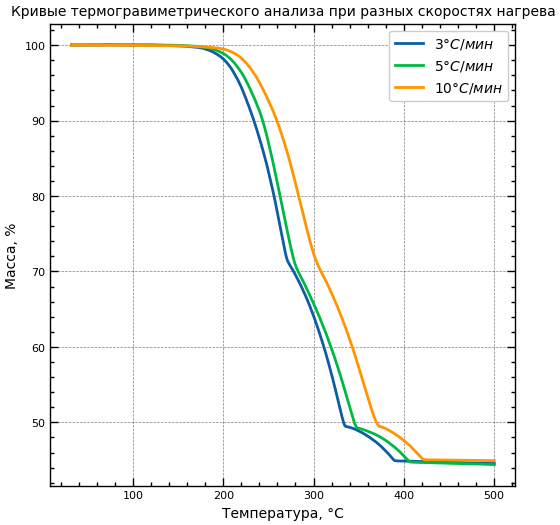

In [26]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(df.index, df['3'], label=r'$3°C/мин$')
axes.plot(df.index, df['5'], label=r'$5°C/мин$')
axes.plot(df.index, df['10'], label=r'$10°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа при разных скоростях нагрева', fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

In [27]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['3'], name=r'$3°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['5'], name=r'$5°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['10'], name=r'$10°C/мин$'))

fig.update_layout(
xaxis=dict(title='Температура, °С'),
yaxis=dict(title='Масса, %'),
title=dict(text='Кривые термогравиметрического анализа при разных скоростях нагрева')
)

fig.update_layout(
legend=dict(
x=1,
y=1,
traceorder="normal",
font=dict(size=10)
),
xaxis_tickfont=dict(size=8),
yaxis_tickfont=dict(size=8)
)

fig.show()

Находим температуры при которых заканчиваются одни реакции и начинаются другие

,start,peak_1,peak_2,peak_3,end
3,181.55357,271.31558,334.33997,390.67996,415.50775
5,189.19289,277.99999,346.75387,406.91351,431.74130
10,204.47153,299.96303,367.76200,422.19215,447.01994


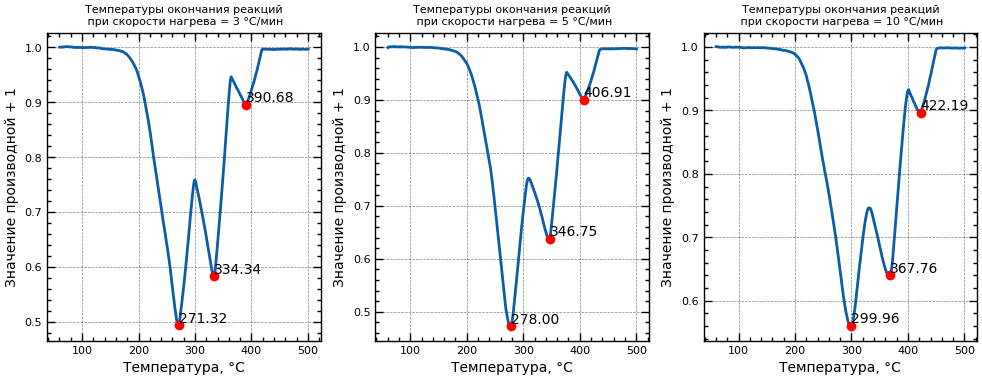

In [28]:
# Определение размера окна для сглаживания
window_size = 30

def find_peaks(df):
    positive_mask = df > 0
    positive_after_negative_mask = positive_mask & (~positive_mask.shift(1, fill_value=True))
    return df[positive_after_negative_mask]

# Инициализация датафрейма с границами начала и конца реакций
peaks_df = pd.DataFrame()

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for idx, heating_rate in enumerate(heating_rates):
    # Сглаживание данных с использованием скользящего среднего
    smoothed_df = df[heating_rate].rolling(window_size).mean()

    # Расчет дифференциала (первой производной) для сглаженных данных
    diff_df = smoothed_df.diff()

    # Более явно подсвечиваем точки перегиба функции
    curve_turn_points = 1 + diff_df

    # Находим температуры при которых реакции начинаются и заканчиваются
    t_start = curve_turn_points[curve_turn_points < 0.985].index.min()
    t_end = curve_turn_points[curve_turn_points < 0.985].index.max()

    # Находим температуры пиков
    peaks = find_peaks(curve_turn_points[(curve_turn_points.index > t_start) & (curve_turn_points.index < t_end)].diff())

    # Обновляем столбцы в датафрейме для каждого heating_rate и заполняем NaN
    columns = ['start'] + [f'peak_{i+1}' for i in range(len(peaks))] + ['end']
    for column in columns:
        if column not in peaks_df.columns:
            peaks_df[column] = np.nan

    peaks_df.at[heating_rate, 'start'] = t_start
    peaks_df.at[heating_rate, 'end'] = t_end
    for i, peak in enumerate(peaks.index):
        peaks_df.at[heating_rate, f'peak_{i+1}'] = peak

    axes[idx].plot(df.index, curve_turn_points)

    # Добавляем заголовок
    axes[idx].set_title(f'Температуры окончания реакций\n при скорости нагрева = {heating_rate} °C/мин', fontsize=SMALL_SIZE)

    # Добавляем подписи на оси
    axes[idx].set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
    axes[idx].set_ylabel('Значение производной + 1', fontsize=MEDIUM_SIZE)

    # Настраиваем размер легенды и подписей осей
    axes[idx].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Выделяем и подписываем точки на графике
    for index in peaks.index:
        peak_value = curve_turn_points[index]
        axes[idx].plot(index, peak_value, 'ro')
        axes[idx].text(index, peak_value, f'{index:.2f}', fontsize=10, ha='left', va='bottom')

peaks_df

Разделяем поле температур на области реакций

In [29]:
# Цикл по скоростям нагрева
for rate in heating_rates:
    # Получаем значения пиков для текущей скорости нагрева
    peaks = peaks_df.loc[rate]

    # Создаем список всех пиков, включая старт и финиш
    peaks_list = [peaks['start']] + [peaks[col] for col in peaks_df.columns if 'peak' in col] + [peaks['end']]

    # Функция для определения реакции
    def get_reaction(temp):
        for i in range(len(peaks_list) - 1):
            if peaks_list[i] <= temp < peaks_list[i + 1]:
                return f'reaction_{i}'
        return 'no_reaction'

    # Применяем функцию к индексу df и создаем новый столбец
    df['reactions_' + str(rate)] = df.index.to_series().apply(get_reaction)

Находим степень конверсии для каждой реакции в каждом значении температуры

In [30]:
for rate in heating_rates:
    reaction_col = f'reactions_{rate}'
    heating_rate_col = f'{rate}'
    conversion_col = f'conversion_{rate}'

    # Получаем начальные и конечные значения температуры для каждой реакции
    df_temp = df[df[reaction_col] != 'no_reaction']
    min_max_mass = df_temp.groupby(reaction_col)[heating_rate_col].agg(['min', 'max'])

    # Создаем новый столбец с нулевыми значениями
    df[conversion_col] = 0

    # Расчет степени превращения для каждой реакции
    for reaction in min_max_mass.index:
        reaction_mask = df[reaction_col] == reaction
        min = min_max_mass.loc[reaction, 'min']
        max = min_max_mass.loc[reaction, 'max']
        df.loc[reaction_mask, conversion_col] = 1 - (df.loc[reaction_mask, heating_rate_col] - min) / (max - min)


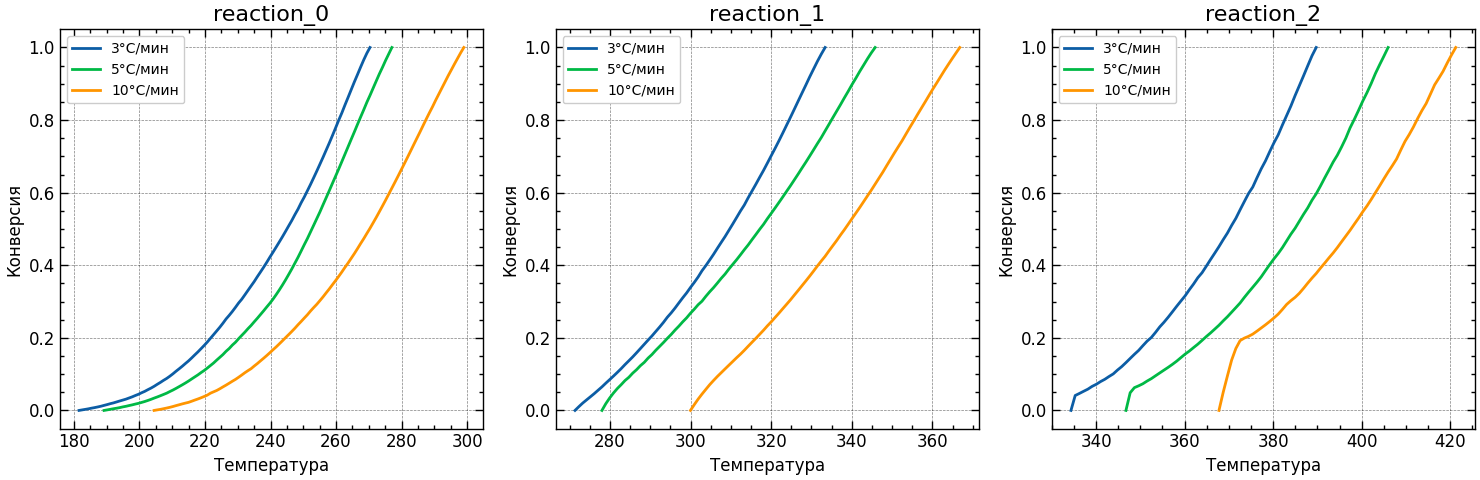

In [31]:
# Получаем уникальные реакции, исключая 'no_reaction', из всех столбцов reactions
all_reactions = pd.unique(df[[f'reactions_{rate}' for rate in heating_rates]].values.ravel())
all_reactions = all_reactions[all_reactions != 'no_reaction']

# Отбрасываем последнюю реакцию
all_reactions = all_reactions[:-1]

# Создайте фигуру с несколькими подграфиками
fig, axs = plt.subplots(1, len(all_reactions), figsize=(5 * len(all_reactions), 5))

# Если есть только одна реакция, axs не будет списком, поэтому обработаем этот случай
if len(all_reactions) == 1:
    axs = [axs]

# Строим графики для каждой реакции
for ax, reaction in zip(axs, all_reactions):
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            ax.plot(df.loc[mask].index, df.loc[mask, conversion_col], label=f'{rate}°С/мин')
    ax.set_title(reaction)
    ax.set_xlabel('Температура', fontsize=BIG_SIZE)
    ax.set_ylabel('Конверсия', fontsize=BIG_SIZE)
    # Настраиваем размер легенды и подписей осей
    ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

plt.tight_layout()
plt.show()


In [32]:
def mins_to_seconds(rate: str) -> int:
    """Преобразует минуты в секунды

    Args:
        rate (str): Строка, содержащая значение в минутах
    Returns:
        int: Преобразованное значение в секундах
    """
    return int(rate) / 60

def get_absolute_T(rate: str, conversion: float, reaction = 'reaction_0') -> np.float64:
    """Получает абсолютное значение температуры для заданной реакции в точке заданной конверсии

    Args:
        rate (str): Значение скорости нагрева
        conversion (float): Значение конверсии
        reaction (str, optional): Название реакции. По умолчанию 'reaction_0'.
    Returns:
        np.float64: Абсолютное значение температуры
    """
    return ((df[df[f'reactions_{rate}'] == reaction][f'conversion_{rate}'] - conversion).abs().idxmin() + 273.15)


def calculate_OFW_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию методом Озавы-Флинна-Уолла

    Args:
        conversion (float): Значение конверсии
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем логарифм скорости нагрева в секундах
    betta = [np.log(mins_to_seconds(rate)) for rate in heating_rates]

    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)

    # Вычисляем активационную энергию
    Ea = coefficient[0] * R / -1.05
    
    return Ea

def calculate_Vyazovkin_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию методом Вязовкина

    Args:
        conversion (float): Значение преобразования
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем логарифм отношения скорости нагрева к квадрату абсолютной температуры
    betta = [np.log(mins_to_seconds(rate) / get_absolute_T(rate, conversion, reaction)**2) for rate in heating_rates]
    
    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]
    
    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)
    
    # Вычисляем активационную энергию
    Ea = -coefficient[0] * R
    
    return Ea


In [33]:
heating_rates = ['3', '5', '10']
# создаем пустой список для хранения данных
data = []

# Задаем диапазон конверсии
conversion_values = np.arange(0.05, 1, 0.05)

# для каждой реакции из списка all_reactions
for reaction in all_reactions:
    # для каждого значения конверсии
    for conversion in conversion_values:
        # вычисляем активационную энергию по методу Вязовкина и Озавы-Флинна-Уолла
        Ea_Vyazovkin = calculate_Vyazovkin_Ea(conversion, reaction)
        Ea_OFW = calculate_OFW_Ea(conversion, reaction)
        
        # добавляем результаты в список
        data.append({'reaction': reaction, 
                     'conversion': conversion, 
                     'Ea_Vyazovkin': Ea_Vyazovkin, 
                     'Ea_OFW': Ea_OFW})

# преобразуем список в DataFrame
Ea_df = pd.DataFrame(data)

# задаем имена столбцов
Ea_df.columns = ['reaction', 'conversion', 'Ea_Vyazovkin', 'Ea_OFW']

Ea_df.head()

,reaction,conversion,Ea_Vyazovkin,Ea_OFW
0,reaction_0,0.05,98.691287,101.671994
1,reaction_0,0.10,106.972789,109.704108
2,reaction_0,0.15,104.615926,107.573659
3,reaction_0,0.20,102.826184,105.951197
4,reaction_0,0.25,100.981190,104.275959


In [34]:
heating_rates

['3', '5', '10']

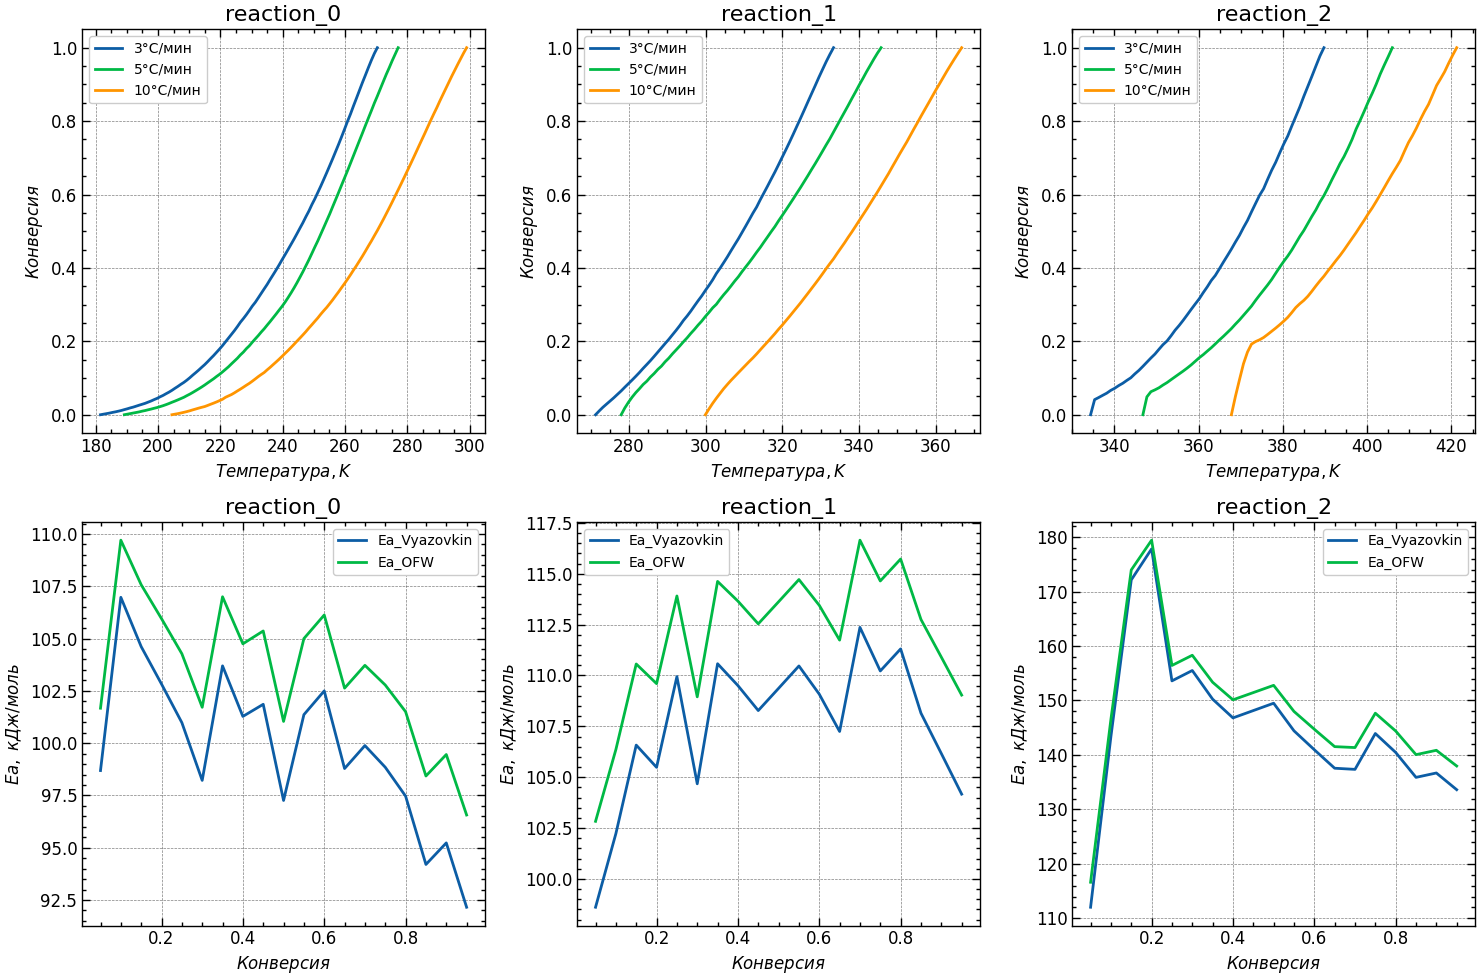

In [35]:
# Создаем фигуру с двумя рядами подграфиков
fig, axs = plt.subplots(2, len(all_reactions), figsize=(5 * len(all_reactions), 10))

# Если есть только одна реакция, axs не будет списком, поэтому обработаем этот случай
if len(all_reactions) == 1:
    axs = np.array([axs])

# Верхний ряд графиков - конверсия от температуры
for ax, reaction in zip(axs[0], all_reactions):
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            ax.plot(df.loc[mask].index, df.loc[mask, conversion_col], label=f'{rate}°С/мин')
    ax.set_title(reaction)
    ax.set_xlabel('$Температура, K$', fontsize=BIG_SIZE)
    ax.set_ylabel('$Конверсия$', fontsize=BIG_SIZE)
    ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

# Нижний ряд графиков - активационная энергия от конверсии
for ax, reaction in zip(axs[1], all_reactions):
    mask = Ea_df['reaction'] == reaction
    if mask.any():
        ax.plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_Vyazovkin'], label='Ea_Vyazovkin')
        ax.plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_OFW'], label='Ea_OFW')
    ax.set_title(reaction)
    ax.set_xlabel('$Конверсия$', fontsize=BIG_SIZE)
    ax.set_ylabel('$Ea,~кДж/моль$', fontsize=BIG_SIZE)
    ax.legend(loc='best', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

plt.tight_layout()
plt.show()



In [56]:
def plot_graphs(conversion, fig, axs, reaction='reaction_0'):
    
    # Очистить предыдущие данные с осей
    for ax in axs.flatten():
        ax.clear()
        
    function_names = ['Вязовкин', 'Озава-Флинн-Уолл']
    y_labels = [r'$\ln\left(\frac{\beta}{{T^2}}\right)$', r'$\ln(\beta)$']
    # График конверсии от температуры реакции
    for i, rate in enumerate(heating_rates):
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            axs[0, 0].plot(df.loc[mask].index, df.loc[mask, conversion_col], label=f'{rate}°C/min')
    axs[0, 0].axhline(y=conversion, color='r', linestyle='-')
    axs[0, 0].set_title('$Конверсия~от~температуры$', fontsize=BIG_SIZE)
    axs[0, 0].set_xlabel('$Температура,~°C$', fontsize=MEDIUM_SIZE)
    axs[0, 0].set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
    axs[0, 0].legend(fontsize=SMALL_SIZE)
    axs[0, 0].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    
    # График зависимости conversion от 'Ea_Vyazovkin' и 'Ea_OFW'
    mask = Ea_df['reaction'] == reaction
    axs[0, 1].plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_Vyazovkin'], label='Ea_Vyazovkin')
    axs[0, 1].plot(Ea_df.loc[mask, 'conversion'], Ea_df.loc[mask, 'Ea_OFW'], label='Ea_OFW')
    axs[0, 1].set_xlim([0, 1])
    axs[0, 1].set_ylim([90, 110])
    axs[0, 1].axvline(x=conversion, color='r', linestyle='-')  # Исправлено на axvline()
    axs[0, 1].set_title(r'$E_{a}$ от конверсии', fontsize=BIG_SIZE)
    axs[0, 1].set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    axs[0, 1].set_ylabel(r'$E_{a}$, кДж/моль', fontsize=MEDIUM_SIZE)
    axs[0, 1].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    axs[0, 1].legend(fontsize=SMALL_SIZE)  
    
    # График для первой графической области (calculate_Vyazovkin_Ea)
    betta = [np.log(mins_to_seconds(rate) / get_absolute_T(rate, conversion, reaction) ** 2) for rate in heating_rates]
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    axs[1, 0].scatter(log_T, betta, label='data points') 

    coefficient = np.polyfit(log_T, betta, 1)
    y_fit = [coefficient[0] * x + coefficient[1] for x in log_T]
    axs[1, 0].plot(log_T, y_fit, label='fit line')

    axs[1, 0].set_title(function_names[0], fontsize=BIG_SIZE)
    axs[1, 0].set_xlabel('1000/T', fontsize=MEDIUM_SIZE)
    axs[1, 0].set_ylabel(y_labels[0], fontsize=MEDIUM_SIZE)
    axs[1, 0].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    
    # График для второй графической области (calculate_OFW_Ea)
    betta = [np.log(mins_to_seconds(rate)) for rate in heating_rates]
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    axs[1, 1].scatter(log_T, betta, label='data points') 

    coefficient = np.polyfit(log_T, betta, 1)
    y_fit = [coefficient[0] * x + coefficient[1] for x in log_T]
    axs[1, 1].plot(log_T, y_fit, label='fit line')

    axs[1, 1].set_title(function_names[1], fontsize=BIG_SIZE)
    axs[1, 1].set_xlabel('1000/T', fontsize=MEDIUM_SIZE)
    axs[1, 1].set_ylabel(y_labels[1], fontsize=MEDIUM_SIZE)
    axs[1, 1].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
    
    plt.tight_layout()   
    

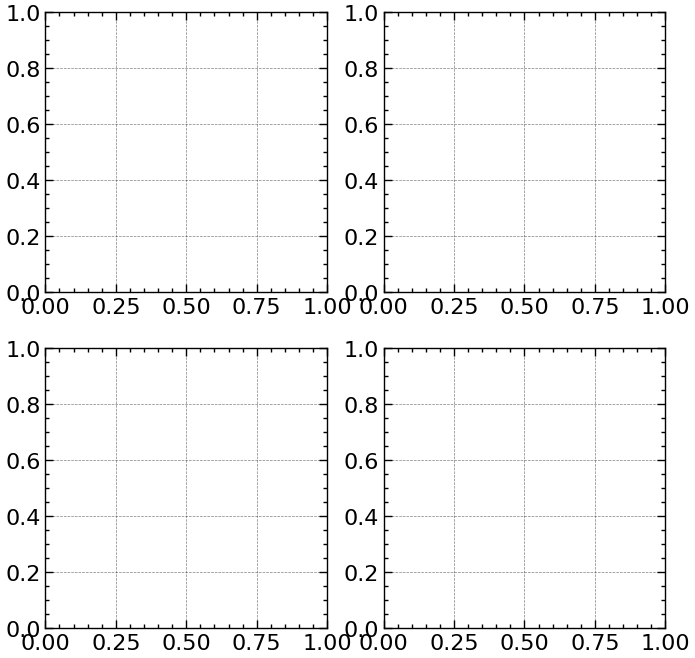

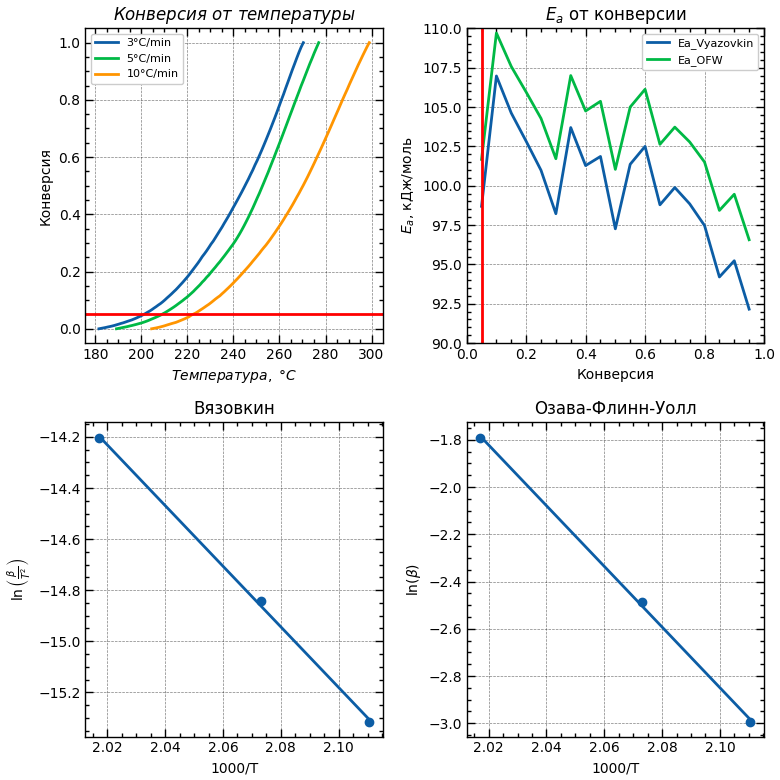

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [60]:
from matplotlib import animation
from matplotlib.animation import PillowWriter, FuncAnimation

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
frames = np.arange(0.05, 1, 0.01)  # Создаем список со значениями конверсии от 0.05 до 0.99 с шагом 0.01
# Определяем функцию, которая будет обновлять график на каждом кадре
def update(frame):
    # Очистка текущего содержимого графика
    for ax in axs.flatten():
        ax.clear()

    # Строим графики
    plot_graphs(frame, fig, axs)

# Создаём фигуру и оси
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Создаём анимацию
ani = FuncAnimation(fig, update, frames=frames)

# Сохраняем анимацию в файл GIF
writer = PillowWriter(fps=24)
ani.save("new_gif.gif", writer=writer)

In [50]:
Ea_df

,reaction,conversion,Ea_Vyazovkin,Ea_OFW
0,reaction_0,0.05,98.691287,101.671994
1,reaction_0,0.10,106.972789,109.704108
2,reaction_0,0.15,104.615926,107.573659
3,reaction_0,0.20,102.826184,105.951197
4,reaction_0,0.25,100.981190,104.275959
5,reaction_0,0.30,98.220615,101.715737
6,reaction_0,0.35,103.695077,106.998834
7,reaction_0,0.40,101.279070,104.749592
8,reaction_0,0.45,101.857980,105.363381
9,reaction_0,0.50,97.260451,101.039743
